
# Imports

In [1]:
import os
os.chdir("D:\PulpitE\FPL_ML")

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import shap
import pickle

from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor

from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_error

from sklearn.preprocessing import LabelEncoder

# Loading data
Data consists of all PL players logs for 2021-22 and 2022-23 seasons\
A single log is just a summary of player performance in a particular match

In [3]:
# loading csv
df_original = pd.read_csv('data/previous/FPL_logs.csv')

df = df_original.copy()

In [4]:
df_original.columns

Index(['Date', 'Day', 'Venue', 'Team', 'Opponent', 'Name', 'Start', 'Pos',
       'Min', 'Gls', 'Ast', 'PK', 'PKatt', 'Sh', 'SoT', 'CrdY', 'CrdR',
       'Touches', 'Tkl', 'Int', 'Blocks', 'xG', 'npxG', 'xA', 'SCA', 'GCA',
       'Cmp', 'Att', 'Cmp%', 'PrgP', 'Carries', 'PrgC', 'T_att', 'T_succ',
       'Season', 'WDL', 'Team_score', 'Opp_score', 'Team_CS', 'Was_home', 'GW',
       'Clean_name', 'FPL_name', 'FPL_team', 'FPL_opp_team', 'Name_original',
       'FPL_pos', 'FPL_ast', 'Bonus', 'Bps', 'Player_CS', 'Creativity',
       'Element', 'Fixture', 'Player_GC', 'Goals_scored', 'ICT_index',
       'Influence', 'Kickoff_time', 'FPL_min', 'Own_goals', 'Penalties_missed',
       'Penalties_saved', 'Saves', 'Selected', 'Threat', 'FPL_points',
       'Transfers_balance', 'Transfers_in', 'Transfers_out', 'Value', 'FPL_GW',
       'xP', 'FPL_xA', 'FPL_xGI', 'FPL_xG', 'FPL_xGC', 'Opp_rating',
       'Team_rating', 'Min_points'],
      dtype='object')

In [5]:
df_original["Name"].unique().size

484

In [6]:
df.shape

(19421, 80)

In [7]:
df["Season"].unique()

array(['2021-22', '2022-23', '2023-24'], dtype=object)

In [8]:
# df = df[~df["FPL_pos"].isin(["GK"])]

In [9]:
df["Season"].unique()

array(['2021-22', '2022-23', '2023-24'], dtype=object)

In [10]:
df = df[df["Season"].isin(['2021-22', '2022-23'])]
# df = df[df["FPL_pos"].isin(['GK'])]

In [11]:
df = df.sort_values(by=["Name", "Date"])

# Feature selection
Model will use a set of standard features and moving averages for some other feature values. In this case we will use moving averages for last 2, 4 and 30 gameweeks.

In [12]:
rolling_gameweeks = [2, 4, 30]
# rolling_gameweeks = [5]

# to_predict = "FPL_points"
to_predict = "xP"
standard_features = [
             "Was_home", # Home/Away
             # "Team_rating", "Opp_rating", 
             "Rating_difference" # Team ratings
             ]
features_to_roll = [
                "Min", 
                # "Start", # time played
                'Gls', 
                # 'Sh', 'SoT', # Goals
                'Ast', # Assists
                # 'CrdY', 'CrdR', # Cards
                "xG", 'xA', # Expected
                'Team_CS', # Defence
                'Team_score', 'Opp_score', 'Team_result', # Team form
                # "xGPoints", "CSPoints", # Position-scaled
                # "Cmp%", "PrgP", "PrgC", "T_succ",
                # 'bonus', 'bps', # Bonus
                # 'ICT_index', # ICT
                "FPL_points", 
                # "Baseline_points", "Bonus" # FPL points
            ]
info = ["Name_original", "GW", "Season", "Team", "Opponent", "Was_home", "Team_rating", "Opp_rating", "FPL_pos", "FPL_points"]

In [13]:
# df[df["Name"] == "Erling-Haaland"]

# Feature engineering

In [14]:
df["Rating_difference"] = df["Team_rating"] / df["Opp_rating"]
df["Baseline_points"] = df["FPL_points"] - df["Bonus"]

In [15]:
def calculate_team_points(row):
    # win - 3 points
    if row['Team_score'] > row['Opp_score']:
        return 3
    # draw - 1 point
    elif row['Team_score'] == row['Opp_score']:
        return 1
    # loss - 0 points
    else:
        return 0
    
df['Team_result'] = df.apply(calculate_team_points, axis=1)

In [16]:
def add_rolling_features(df, standard_features, features_to_roll):
    features = standard_features
    
    for r in rolling_gameweeks:
        form_means = df.groupby(["Name"])[features_to_roll].rolling(r, min_periods=1).mean().groupby(["Name"]).shift(1).reset_index()
        # print(form_means[form_means["Name"] == "Erling-Haaland"])
        form_means = form_means.fillna(method='bfill') # slightly incorrect, better to drop Nan
        form_means.columns = [f'{col}{"_"}{r}' for col in form_means.columns]
        features += form_means.columns.tolist()
        features = list(filter(lambda x: x not in ["Name_" + str(r)], features))
        df = pd.concat([df.reset_index(), form_means], axis=1)
        # df = df.merge(form_means, left_index=True, right_index=True)
        df = df.drop([col for col in df.columns if col.startswith('level')], axis=1)
        
    return df.reset_index(), features

In [17]:
def ohe(df, ohe_columns, features):
    # one hot encoding
    for c in ohe_columns:
        ohe_c = pd.get_dummies(df[c], dtype="int64")
        df = pd.concat([df, ohe_c], axis=1)

        features += ohe_c.columns.tolist()
        
    return df, features

In [18]:
def label_encoding(df, column_to_encode):
    
    mapping_dict = {
        'Y': 1, # Starting eleven
        'Y*': 1, # Starting eleven as captain
        'N': 0, # Not in starting eleven
    }
    
    df[column_to_encode] = df[column_to_encode].map(mapping_dict)
    
    return df

In [19]:
df = label_encoding(df, "Start")

In [20]:
df, features = add_rolling_features(df, standard_features, features_to_roll)

In [21]:
df, features = ohe(df, ["FPL_pos"], features)
if "GK" in df.columns:
    df = df.drop("GK", axis=1)
    features.remove("GK")

In [22]:
# dropping unwanted columns
features = [col for col in features if not col.startswith('level')]
df = df[np.unique(features + info + [to_predict])]

In [23]:
df = df[pd.to_numeric(df["GW"], errors="coerce").notna()]
df["GW"] = df["GW"].astype("uint64")

In [24]:
# dropping NaNs
df = df.dropna(axis=0)

In [25]:
# df = df.set_index(["Name_original", "Season", "GW"], drop=False)

In [26]:
df.columns

Index(['Ast_2', 'Ast_30', 'Ast_4', 'DEF', 'FPL_points', 'FPL_points_2',
       'FPL_points_30', 'FPL_points_4', 'FPL_pos', 'FWD', 'GW', 'Gls_2',
       'Gls_30', 'Gls_4', 'MID', 'Min_2', 'Min_30', 'Min_4', 'Name_original',
       'Opp_rating', 'Opp_score_2', 'Opp_score_30', 'Opp_score_4', 'Opponent',
       'Rating_difference', 'Season', 'Team', 'Team_CS_2', 'Team_CS_30',
       'Team_CS_4', 'Team_rating', 'Team_result_2', 'Team_result_30',
       'Team_result_4', 'Team_score_2', 'Team_score_30', 'Team_score_4',
       'Was_home', 'xA_2', 'xA_30', 'xA_4', 'xG_2', 'xG_30', 'xG_4', 'xP'],
      dtype='object')

In [27]:
df.shape

(17148, 45)

In [28]:
# saving to file
df.set_index(["Name_original", "Season", "GW"], drop=False).to_csv("data/misc/df_features.csv", index=False) # keeping GKs on

In [29]:
df = df[~df["FPL_pos"].isin(["GK"])] # only outfield players

# Data split into train and valid
Let's take entire 2021-22 season and 30 first gameweeks of 2022-23 season as training data and 8 last gameweeks of that season as valid data (~10% of all rows).

In [30]:
def shrink_df_to_top_players(df, n_players, min_fixtures):
    # Calculate average scores
    average_scores = df.groupby('Name_original')[to_predict].mean()
    
    # Calculate player counts
    player_counts = df['Name_original'].value_counts()
    
    # Filter out players with less than min_fixtures occurrences
    popular_players = player_counts[player_counts >= min_fixtures].index
    
    print("Unique players with min_fixtures:", popular_players.size)

    # Sort players by average scores
    sorted_players = average_scores.sort_values(ascending=False)

    # Get the top n_players players
    top_popular_players = sorted_players[sorted_players.index.isin(popular_players)].head(n_players)

    # Filter the original DataFrame
    top_players_df = df[df['Name_original'].isin(top_popular_players.index)]
    
    print("Unique players left:", top_players_df['Name_original'].unique().size)
    
    return top_players_df

In [31]:
CUT_OFF_GAMEWEEK = 31
SEASON_TO_PREDICT = "2022-23"

In [32]:
df_train = shrink_df_to_top_players(df, 550, 10)
# df_train["Name_original"].unique()

Unique players with min_fixtures: 354
Unique players left: 354


In [33]:
df = df.set_index(["Name_original", "Season", "GW"], drop=False)

In [34]:
# training data
X_train = df_train[((df_train["Season"] < SEASON_TO_PREDICT) | (df_train["GW"] <= CUT_OFF_GAMEWEEK - 1))][features].reset_index(drop=True)
y_train = df_train[((df_train["Season"] < SEASON_TO_PREDICT) | (df_train["GW"] <= CUT_OFF_GAMEWEEK - 1))][to_predict].reset_index(drop=True)

In [35]:
# only 31st gameweek
X_test = df[(df["GW"] == CUT_OFF_GAMEWEEK) & (df["Season"] == SEASON_TO_PREDICT) ][features].reset_index(drop=True)
y_test = df[(df["GW"] == CUT_OFF_GAMEWEEK) & (df["Season"] == SEASON_TO_PREDICT) ][to_predict].reset_index(drop=True)

In [36]:
# all remaining gameweeks
X_test_all_remaining = df[(df["GW"] >= CUT_OFF_GAMEWEEK) & (df["Season"] == SEASON_TO_PREDICT) ][features].reset_index(drop=True)
y_test_all_remaining = df[(df["GW"] >= CUT_OFF_GAMEWEEK) & (df["Season"] == SEASON_TO_PREDICT) ]["FPL_points"].reset_index(drop=True)

In [37]:
X_train.shape, X_test.shape, X_test_all_remaining.shape

((13389, 35), (231, 35), (1962, 35))

# Model

In [38]:
# model = GradientBoostingRegressor(random_state=42)
model = XGBRegressor(
        random_state=42,
        n_estimators=500,
        early_stopping_rounds=5,
        learning_rate=0.2
    )
# model = RandomForestRegressor(random_state=42)

In [39]:
%%time
model.fit(
        X_train, 
        y_train,
        eval_set=[(X_test_all_remaining, y_test_all_remaining)],
        verbose=False
    )

CPU times: total: 2.02 s
Wall time: 322 ms


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=5,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.2, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

# Getting predictions

In [40]:
def get_predictions(model, df, X, all_remaining=False):
    # make predictions on the test data and glues them to the rest of the dataframe
    predictions = model.predict(X)
    
    if all_remaining:
        df_predictions = df[(df["GW"] >= CUT_OFF_GAMEWEEK) & (df["Season"] == SEASON_TO_PREDICT)].reset_index(drop=True)
    else:
        df_predictions = df[(df["GW"] == CUT_OFF_GAMEWEEK) & (df["Season"] == SEASON_TO_PREDICT)].reset_index(drop=True)
        
    df_predictions.loc[:, "Pred"] = predictions
    
    preds = df_predictions[info + [to_predict] + ["Pred"]].sort_values(by=["Pred"], ascending = False)
    
    return preds, predictions

In [41]:
preds, predictions = get_predictions(model, df, X_test)

In [42]:
preds_all_gameweeks, predictions_all = get_predictions(model, df, X_test_all_remaining, True)

In [43]:
df.columns

Index(['Ast_2', 'Ast_30', 'Ast_4', 'DEF', 'FPL_points', 'FPL_points_2',
       'FPL_points_30', 'FPL_points_4', 'FPL_pos', 'FWD', 'GW', 'Gls_2',
       'Gls_30', 'Gls_4', 'MID', 'Min_2', 'Min_30', 'Min_4', 'Name_original',
       'Opp_rating', 'Opp_score_2', 'Opp_score_30', 'Opp_score_4', 'Opponent',
       'Rating_difference', 'Season', 'Team', 'Team_CS_2', 'Team_CS_30',
       'Team_CS_4', 'Team_rating', 'Team_result_2', 'Team_result_30',
       'Team_result_4', 'Team_score_2', 'Team_score_30', 'Team_score_4',
       'Was_home', 'xA_2', 'xA_30', 'xA_4', 'xG_2', 'xG_30', 'xG_4', 'xP'],
      dtype='object')

# Custom metric
Such models are usually used to compare players and decide who to pick for upcoming gameweek(s). For each player pair in a subset of players model can either predict the outcome well (e.g. player A scores more than player B and model predicts exactly that) or predict wrongly (e.g. player A scores more than player B but model predicts player B > player A). Pairwise_accuracy returns the percentage of corrected predicted pairs. Pairwise_accuracy_topX is a variation of this metric calculated only for X highest scoring players of last two seasons.

In [44]:
def get_top_performer_names(df, no_top, no_gws):
    # takes no_top players that recorded highest average FPL points in no_gws last gameweeks
    return df.reset_index(drop=True).groupby("Name_original")[to_predict].mean().groupby("Name_original").tail(no_gws).sort_values(ascending=False).head(no_top).index.to_list()

In [45]:
def pairwise_accuracy(predicted_scores, true_scores):
    if len(predicted_scores) != len(true_scores):
        raise ValueError("The length of predicted_scores and true_scores must be the same.")

    num_pairs = 0
    num_correct_pairs = 0

    for i in range(len(predicted_scores)):
        for j in range(i + 1, len(predicted_scores)):
            # Check if the predicted order matches the true order
            if (predicted_scores[i] > predicted_scores[j] and true_scores[i] > true_scores[j]) or \
               (predicted_scores[i] < predicted_scores[j] and true_scores[i] < true_scores[j]):
                num_correct_pairs += 1
            num_pairs += 1

    pairwise_accuracy = num_correct_pairs / num_pairs
    return pairwise_accuracy

In [46]:
def pairwise_accuracy_topX(model, df, top_x, all_gw=False):
    # pairwise_accuracy for top_X players
    if all_gw:
        top_performers = df[(df["GW"] == CUT_OFF_GAMEWEEK) & (df["Season"] == SEASON_TO_PREDICT) & (df["Name_original"].isin(get_top_performer_names(df, top_x, 50)))]
    else:
        top_performers = df[(df["GW"] >= CUT_OFF_GAMEWEEK) & (df["Season"] == SEASON_TO_PREDICT) & (df["Name_original"].isin(get_top_performer_names(df, top_x, 50)))]

    X = top_performers[features].reset_index(drop=True)
    y = np.array(top_performers[to_predict].reset_index(drop=True))
    preds = model.predict(X)
    
    return  pairwise_accuracy(preds, y)

# Evaluation

In [47]:
def evaluate(model, df, predictions, y_true, all_gw=False):
    # function to calculate different metrics for a given model
    mae = mean_absolute_error(y_true, predictions)
    mse = mean_squared_error(y_true, predictions)

    pairwise_acc = pairwise_accuracy(np.array(y_true), predictions)
    pairwise_accuracy_top20 = pairwise_accuracy_topX(model, df, 20, all_gw)
    pairwise_accuracy_top100 = pairwise_accuracy_topX(model, df, 100, all_gw)
    
    print("MAE:", mae)
    print("MSE:", mse)
    print("Pairwise accuracy:", pairwise_acc)
    print("Pairwise accuracy @TOP100:", pairwise_accuracy_top100)
    print("Pairwise accuracy @TOP20:", pairwise_accuracy_top20)
    print("Avg pred vs avg true:", np.mean(predictions).round(2), "vs", np.mean(y_true).round(2).item())

In [48]:
# df[(df["GW"] == GAMEWEEK_TO_PREDICT) & (df["Season"] == SEASON_TO_PREDICT) & (df["Name"].isin(get_top_performer_names(df, 20, 50)))].columns

In [49]:
# next gameweek
evaluate(model, df, predictions, y_test, all_gw=False)

MAE: 1.0780892730275273
MSE: 2.3222481645036357
Pairwise accuracy: 0.6008658008658009
Pairwise accuracy @TOP100: 0.5447117695287099
Pairwise accuracy @TOP20: 0.5530501089324619
Avg pred vs avg true: 1.83 vs 1.87


In [50]:
# all remaining gameweeks
evaluate(model, df, predictions_all, y_test_all_remaining, all_gw=True)

MAE: 1.7619517416020174
MSE: 8.130045258153098
Pairwise accuracy: 0.5434073505736999
Pairwise accuracy @TOP100: 0.508751902587519
Pairwise accuracy @TOP20: 0.6190476190476191
Avg pred vs avg true: 1.86 vs 2.36


In [51]:
# df[df["Name"] == "Abdoulaye-Doucoure"][info]

In [52]:
# model.predict(df[df["GW"] == GAMEWEEK_TO_PREDICT][df["Name"] == "Mohamed-Salah"][features])

In [53]:
features

['Was_home',
 'Rating_difference',
 'Min_2',
 'Gls_2',
 'Ast_2',
 'xG_2',
 'xA_2',
 'Team_CS_2',
 'Team_score_2',
 'Opp_score_2',
 'Team_result_2',
 'FPL_points_2',
 'Min_4',
 'Gls_4',
 'Ast_4',
 'xG_4',
 'xA_4',
 'Team_CS_4',
 'Team_score_4',
 'Opp_score_4',
 'Team_result_4',
 'FPL_points_4',
 'Min_30',
 'Gls_30',
 'Ast_30',
 'xG_30',
 'xA_30',
 'Team_CS_30',
 'Team_score_30',
 'Opp_score_30',
 'Team_result_30',
 'FPL_points_30',
 'DEF',
 'FWD',
 'MID']

In [54]:
len(features)

35

# Predictions - next gameweek only

In [55]:
preds.head(30)

,Name_original,GW,Season,Team,Opponent,Was_home,Team_rating,Opp_rating,FPL_pos,FPL_points,xP,Pred
68,Erling Haaland,31,2022-23,Manchester City,Leicester City,1.0,2060.531738,1722.042969,FWD,2.0,6.8,4.911250
78,Gabriel dos Santos Magalhães,31,2022-23,Arsenal,West Ham,0.0,1946.847900,1751.608521,DEF,1.0,2.2,3.950930
90,Ivan Toney,31,2022-23,Brentford,Wolves,0.0,1782.324097,1717.951904,FWD,2.0,3.0,3.697346
143,Manuel Akanji,31,2022-23,Manchester City,Leicester City,1.0,2060.531738,1722.042969,DEF,2.0,1.0,3.590052
45,Cristian Romero,31,2022-23,Tottenham,Bournemouth,1.0,1851.721558,1665.276123,DEF,1.0,1.0,3.369484
208,Son Heung-min,31,2022-23,Tottenham,Bournemouth,1.0,1851.721558,1665.276123,MID,9.0,5.2,3.296094
150,Gabriel Martinelli Silva,31,2022-23,Arsenal,West Ham,0.0,1946.847900,1751.608521,MID,5.0,3.6,3.286969
79,Gabriel Fernando de Jesus,31,2022-23,Arsenal,West Ham,0.0,1946.847900,1751.608521,FWD,7.0,4.2,3.283657
67,Eric Dier,31,2022-23,Tottenham,Bournemouth,1.0,1851.721558,1665.276123,DEF,1.0,1.0,3.279880
22,Benjamin White,31,2022-23,Arsenal,West Ham,0.0,1946.847900,1751.608521,DEF,6.0,3.4,3.277134


In [56]:
preds[preds["Team"] == "Manchester City"].head(20)

,Name_original,GW,Season,Team,Opponent,Was_home,Team_rating,Opp_rating,FPL_pos,FPL_points,xP,Pred
68,Erling Haaland,31,2022-23,Manchester City,Leicester City,1.0,2060.531738,1722.042969,FWD,2.0,6.8,4.911250
143,Manuel Akanji,31,2022-23,Manchester City,Leicester City,1.0,2060.531738,1722.042969,DEF,2.0,1.0,3.590052
128,Kevin De Bruyne,31,2022-23,Manchester City,Leicester City,1.0,2060.531738,1722.042969,MID,3.0,2.5,3.221702
170,Nathan Aké,31,2022-23,Manchester City,Leicester City,1.0,2060.531738,1722.042969,DEF,1.0,0.0,3.105519
198,Rúben Gato Alves Dias,31,2022-23,Manchester City,Leicester City,1.0,2060.531738,1722.042969,DEF,0.0,1.0,2.937500
91,Jack Grealish,31,2022-23,Manchester City,Leicester City,1.0,2060.531738,1722.042969,MID,0.0,1.5,2.918971
118,John Stones,31,2022-23,Manchester City,Leicester City,1.0,2060.531738,1722.042969,DEF,0.0,1.0,2.739365
123,Julián Álvarez,31,2022-23,Manchester City,Leicester City,1.0,2060.531738,1722.042969,FWD,2.0,1.0,2.618854
197,Rodrigo Hernandez,31,2022-23,Manchester City,Leicester City,1.0,2060.531738,1722.042969,MID,1.0,2.0,2.402291
195,Riyad Mahrez,31,2022-23,Manchester City,Leicester City,1.0,2060.531738,1722.042969,MID,10.0,2.9,2.357250


# Predictions - all remaining gameweeks

In [57]:
preds_all_gameweeks.head(15)

,Name_original,GW,Season,Team,Opponent,Was_home,Team_rating,Opp_rating,FPL_pos,FPL_points,xP,Pred
595,Erling Haaland,38,2022-23,Manchester City,Brentford,0.0,2083.640381,1807.119507,FWD,0.0,0.0,5.226665
591,Erling Haaland,35,2022-23,Manchester City,Leeds United,1.0,2069.102051,1662.209595,FWD,0.0,5.0,4.986057
588,Erling Haaland,31,2022-23,Manchester City,Leicester City,1.0,2060.531738,1722.042969,FWD,2.0,6.8,4.911250
1398,Mohamed Salah,38,2022-23,Liverpool,Southampton,0.0,1950.095581,1616.916626,MID,5.0,7.6,4.766844
681,Gabriel Fernando de Jesus,32,2022-23,Arsenal,Southampton,1.0,1936.194092,1635.812866,FWD,2.0,5.4,4.689402
593,Erling Haaland,37,2022-23,Manchester City,Chelsea,1.0,2087.472656,1794.311890,FWD,1.0,1.4,4.655262
244,Bruno Borges Fernandes,36,2022-23,Manchester Utd,Wolves,1.0,1841.589233,1725.502686,MID,6.0,7.0,4.601593
1394,Mohamed Salah,34,2022-23,Liverpool,Tottenham,1.0,1933.697876,1817.128296,MID,7.0,5.5,4.503688
1396,Mohamed Salah,36,2022-23,Liverpool,Leicester City,0.0,1944.225098,1709.140503,MID,14.0,8.2,4.395082
1281,Martin Ødegaard,38,2022-23,Arsenal,Wolves,1.0,1909.242798,1722.064575,MID,3.0,3.2,4.377931


In [58]:
preds_all_gameweeks[preds_all_gameweeks["Name_original"] == "Mohamed Salah"].sort_values(by=["GW"])

,Name_original,GW,Season,Team,Opponent,Was_home,Team_rating,Opp_rating,FPL_pos,FPL_points,xP,Pred
1392,Mohamed Salah,32,2022-23,Liverpool,Nott'ham Forest,1.0,1926.870483,1623.869263,MID,7.0,3.3,4.310015
1393,Mohamed Salah,33,2022-23,Liverpool,West Ham,0.0,1928.467651,1771.272461,MID,2.0,1.5,3.506288
1394,Mohamed Salah,34,2022-23,Liverpool,Tottenham,1.0,1933.697876,1817.128296,MID,7.0,5.5,4.503688
1395,Mohamed Salah,35,2022-23,Liverpool,Brentford,1.0,1940.118652,1782.052979,MID,10.0,7.6,4.044013
1396,Mohamed Salah,36,2022-23,Liverpool,Leicester City,0.0,1944.225098,1709.140503,MID,14.0,8.2,4.395082
1397,Mohamed Salah,37,2022-23,Liverpool,Aston Villa,1.0,1955.095703,1812.286499,MID,5.0,2.7,3.914156
1398,Mohamed Salah,38,2022-23,Liverpool,Southampton,0.0,1950.095581,1616.916626,MID,5.0,7.6,4.766844


In [59]:
preds_all_gameweeks[preds_all_gameweeks["Name_original"] == "Erling Haaland"].sort_values(by=["GW"])

,Name_original,GW,Season,Team,Opponent,Was_home,Team_rating,Opp_rating,FPL_pos,FPL_points,xP,Pred
588,Erling Haaland,31,2022-23,Manchester City,Leicester City,1.0,2060.531738,1722.042969,FWD,2.0,6.8,4.911250
594,Erling Haaland,32,2022-23,Manchester City,Brighton,0.0,2089.150391,1826.267822,FWD,5.0,6.6,3.684100
589,Erling Haaland,33,2022-23,Manchester City,Arsenal,1.0,2057.953369,1928.582397,FWD,14.0,8.6,3.693705
590,Erling Haaland,34,2022-23,Manchester City,Fulham,0.0,2064.563232,1717.714233,FWD,8.0,6.0,4.141234
591,Erling Haaland,35,2022-23,Manchester City,Leeds United,1.0,2069.102051,1662.209595,FWD,0.0,5.0,4.986057
592,Erling Haaland,36,2022-23,Manchester City,Everton,0.0,2071.091064,1694.975464,FWD,7.0,2.6,4.058164
593,Erling Haaland,37,2022-23,Manchester City,Chelsea,1.0,2087.472656,1794.311890,FWD,1.0,1.4,4.655262
595,Erling Haaland,38,2022-23,Manchester City,Brentford,0.0,2083.640381,1807.119507,FWD,0.0,0.0,5.226665


# Saving to file

In [60]:
preds_all_gameweeks.to_csv("predictions/all_predictions.csv", index=False)

In [61]:
pickle.dump(model, open("models/GBR.pkl", 'wb'))

# Feature importance and influence

In [62]:
explainer = shap.Explainer(model.predict, X_test_all_remaining)
shap_values = explainer(X_test_all_remaining)

Permutation explainer: 1963it [02:32, 12.30it/s]                                                                                                 


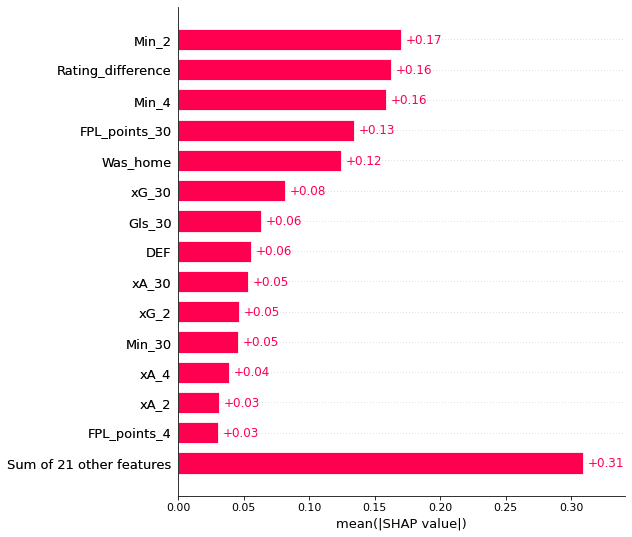

In [63]:
shap.plots.bar(shap_values, max_display=15)

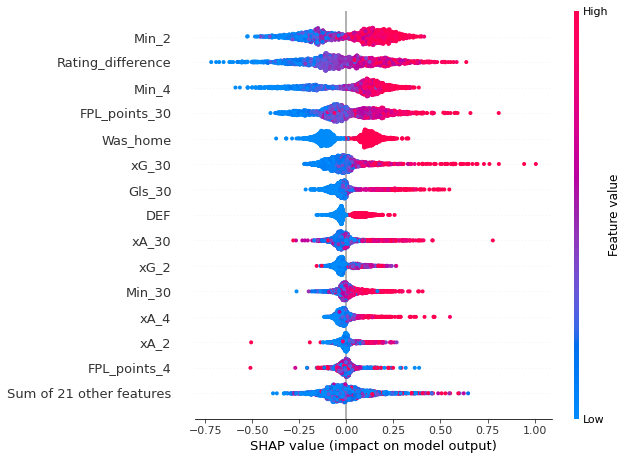

In [64]:
shap.plots.beeswarm(shap_values, max_display=15)

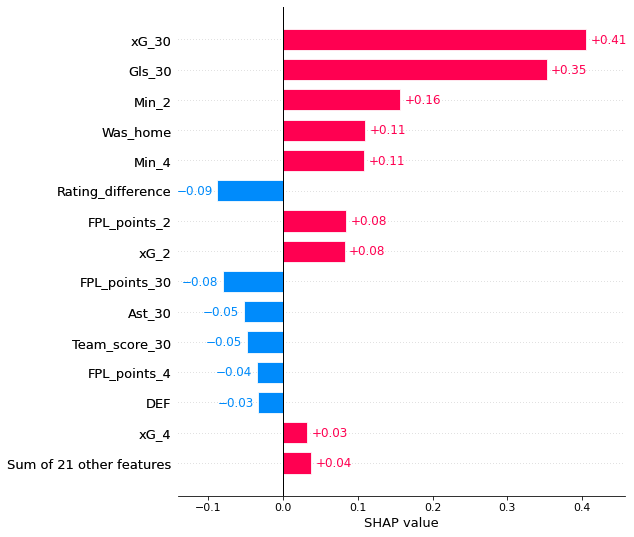

In [65]:
# explaining Erling Haaland`s score in gameweek 31
shap.plots.bar(shap_values[69], max_display=15)

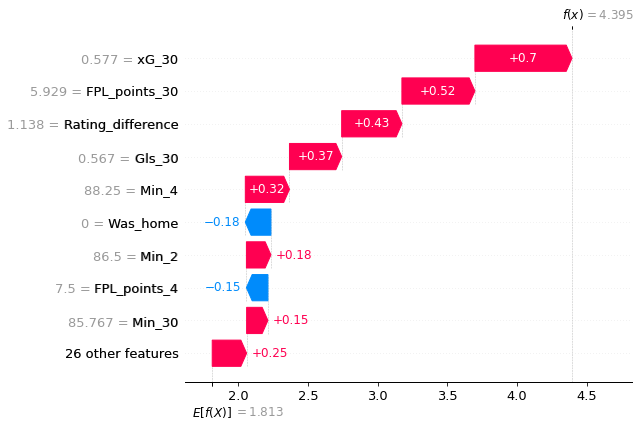

In [66]:
# Salah vs Nottingham Forest
shap.plots.waterfall(shap_values[1396])